# Correlation Assignment

If you are using Google Colab to finish your assignment, make a copy to your own drive and edit.
If you are running on your own local machine, you can install the `colab` extension in your own VSCode, and running with the colab kernel.


**Your name (unique name)**: zejunli

**Your U-M ID**: 09403559

In [4]:
# Load libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

To get p-values, you have to use a library specifically built for statistical testing, like _SciPy_.

`scipy` is the gold standard for scientific computing, but it is designed to calculate the correlation and p-value for one pair of variables at a time. It doesn't have a single "matrix" function like `df.corr()`.

To create the correlation matrix and get p-values using `scipy`, you need to iterate through your column combinations.

In [5]:
def get_scipy_corrs(df, variables):
    """
    This is a helper function that returns a correlation matrix with p-values from scipy.

    Args:
      df (pandas.DataFrame): The input DataFrame.
      variables (list): A list of column names to calculate correlations for.

    Returns:
      tuple: A tuple containing two pandas DataFrames:
        - r_df (pandas.DataFrame): Correlation matrix with correlation coefficients.
        - p_df (pandas.DataFrame): Correlation matrix with p-values.
    """
    n = len(variables)
    # Initialize with NaNs to handle cases where calculation fails
    p_matrix = np.full((n, n), np.nan)
    r_matrix = np.full((n, n), np.nan)

    for i in range(n):
        for j in range(n):
            # 1. Select the two columns and drop rows where either is NaN
            subset = df[[variables[i], variables[j]]].dropna()

            # 2. Ensure data is numeric and flattened to 1D arrays
            x = subset[variables[i]].astype(float).values
            y = subset[variables[j]].astype(float).values

            # 3. Calculate (requires at least 2 points for a correlation)
            if len(x) > 1:
                try:
                    res = stats.pearsonr(x, y)
                    r_matrix[i, j] = res.statistic
                    p_matrix[i, j] = res.pvalue
                except:
                    continue # Skip pairs that cause math errors (e.g. zero variance)

    # Return as clean DataFrames
    r_df = pd.DataFrame(r_matrix, index=variables, columns=variables)
    p_df = pd.DataFrame(p_matrix, index=variables, columns=variables)
    return r_df, p_df


def format_sig_stars(p):
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return ''

def combine_r_and_p(r_df, p_df):
    """
    This is a helper function that combines the correlation and p-values.
    """
    combined = r_df.copy().astype(str)

    for i in range(len(r_df.index)):
        for j in range(len(r_df.columns)):
            r_val = r_df.iloc[i, j]
            p_val = p_df.iloc[i, j]

            if pd.isna(r_val) or pd.isna(p_val):
                combined.iloc[i, j] = ""
                continue

            stars = format_sig_stars(p_val)
            # Format: 0.123*** (p=0.002)
            combined.iloc[i, j] = f"{r_val:.3f}{stars}\n({p_val:.3f})"

    return combined


Creating a table that follows APA conventions is a little tricky. We've written a function to help you.

In [6]:
def export_apa_correlation(r_df, p_df):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(r_df, dtype=bool))

    # Initialize the formatted DataFrame
    apa_df = r_df.copy().astype(str)

    for i in range(len(r_df.index)):
        for j in range(len(r_df.columns)):
            # Hide the upper triangle and diagonal
            if i <= j:
                apa_df.iloc[i, j] = ""
                continue

            r_val = r_df.iloc[i, j]
            p_val = p_df.iloc[i, j]

            # Add stars
            stars = ""
            if p_val < .001: stars = "***"
            elif p_val < .01: stars = "**"
            elif p_val < .05: stars = "*"

            # Format to 2 or 3 decimal places (APA usually uses 2 or 3)
            # This version keeps 3 for precision
            formatted_r = f"{r_val:.2f}".replace("0.", ".") # Remove leading zero for APA style
            apa_df.iloc[i, j] = f"{formatted_r}{stars}"

    # Rename columns to 1, 2, 3... to follow APA table headers
    apa_df.columns = [f"{i+1}." for i in range(len(apa_df.columns))]
    # Add the variable names as the first column
    apa_df.insert(0, "Variable", r_df.index)
    # Add a column for the index numbers
    apa_df.insert(0, "№", range(1, len(apa_df) + 1))

    return apa_df

## Load the data

You'll need to download the data from the link in the assignment on Canvas. The filename you're looking for is `Dawtry Sutton and Sibley 2015 Study 1a.csv`.

In [7]:
# Load the Dawtry et al. (2015) Study 1a data
file_id = '0Bz-rhZ21ShvOMGxnYUJfYmR5d2M'
resource_key = '0-jo7UtjyXsahMUKXVOQvb9g'

# Construct a direct download link
direct_link = f'https://drive.google.com/uc?export=download&id={file_id}&resourcekey={resource_key}'
df = pd.read_csv(direct_link)

# IF YOU ARE RUNNING ON YOUR OWN LAPTOP, UNCOMMENT AND ADD THE FILEPATH
# df = pd.read_csv('')  # Add the correct path to the CSV file here

# Explore the dataframe
print(f"Shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

Shape: (305, 37)

Column names:
['PS', 'PD_15', 'PD_30', 'PD_45', 'PD_60', 'PD_75', 'PD_90', 'PD_105', 'PD_120', 'PD_135', 'PD_150', 'PD_150plus', 'fairness', 'satisfaction', 'SC_15', 'SC_30', 'SC_45', 'SC_60', 'SC_75', 'SC_90', 'SC_105', 'SC_120', 'SC_135', 'SC_150', 'SC_150plus', 'redist1', 'redist2', 'redist3', 'redist4', 'Household_Income', 'Political_Preference', 'age', 'gender', 'Population_Inequality_Gini_Index', 'Population_Mean_Income', 'Social_Circle_Inequality_Gini_Index', 'Social_Circle_Mean_Income']

First few rows:
    PS  PD_15  PD_30  PD_45  PD_60  PD_75  PD_90  PD_105  PD_120  PD_135  ...  \
0  233     27     48     21      0      0      0       0       0       0  ...   
1  157     39      0      0      0      0      0       0       0       0  ...   
2  275      0      0     50      0      0     50       0       0       0  ...   
3  111      9     14     17     17     17      8       7       5       2  ...   
4   52     68     32      0      0      0      0       0    

## Data cleaning

This section TO-DO list:
  1. Understand the data with descriptive analysis
  2. Compute two new variables

Compute the two variables:  
1. You should first create a score that captures participants’ perceptions that the current system is fair and satisfactory. To do this, COMPUTE the mean for the items fairness and satisfaction, naming this new variable `fairness_and_satisfaction`.    
2. Next, you should create a score that captures participants’ support for redistribution. The researchers asked participants four questions in total, two asked about their support for redistribution, and two asked about their opposition to redistribution.
3. To create a single score that reflect participants overall view toward redistribution, we first need to recode the two items that assess opposition to redistribution. Reverse score redist2 and redist4, so that 6 = 1, 5 = 2, 4 = 3, 3 = 4, 2 = 5, 1 = 6. Name the recoded variables `redist2_recode` and `redist4_recode`.
4. Now, COMPUTE the mean for the items `redist1`, `redist2_recode`, `redist3`, `redist4_recode`, naming this new variable `support_for_redistribution`.


In [8]:
# These are the relevant variables we'll use
relevant_vars = ['fairness', 'satisfaction',
                  'redist1', 'redist2', 'redist3', 'redist4',
                  'Household_Income', 'Social_Circle_Mean_Income',
                  'Population_Mean_Income', 'Social_Circle_Inequality_Gini_Index',
                  'Population_Inequality_Gini_Index', 'Political_Preference']

In [9]:
# Data description, you can use .info() or .describe()
## TODO: Conduct descriptive analysis, notice any missingness and weird stats
## Remember to check the variables relevant to our study

print(df[relevant_vars].info()) # .info() to check the missingness

print(df[relevant_vars].describe()) # .describe() to easily check the descriptive stats of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   fairness                             305 non-null    int64  
 1   satisfaction                         305 non-null    int64  
 2   redist1                              305 non-null    int64  
 3   redist2                              305 non-null    int64  
 4   redist3                              305 non-null    int64  
 5   redist4                              305 non-null    int64  
 6   Household_Income                     305 non-null    object 
 7   Social_Circle_Mean_Income            305 non-null    int64  
 8   Population_Mean_Income               305 non-null    int64  
 9   Social_Circle_Inequality_Gini_Index  305 non-null    float64
 10  Population_Inequality_Gini_Index     305 non-null    float64
 11  Political_Preference            

In [10]:
# Creating two new variables
## First step: compute the mean of fairness and satisfaction
df['fairness_and_satisfaction'] = df[['fairness', 'satisfaction']].mean(axis=1)

## Remember to double check if the new variable works
print(f"New variable created: {df['fairness_and_satisfaction'].describe()}")
print(f"\nMissing values: {df['fairness_and_satisfaction'].isna().sum()}")
print(df[['fairness', 'satisfaction', 'fairness_and_satisfaction']].head(10)) # use this code to check

New variable created: count    305.000000
mean       3.539344
std        2.024950
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        9.000000
Name: fairness_and_satisfaction, dtype: float64

Missing values: 0
   fairness  satisfaction  fairness_and_satisfaction
0         1             1                        1.0
1         5             2                        3.5
2         5             5                        5.0
3         7             7                        7.0
4         4             5                        4.5
5         1             4                        2.5
6         3             3                        3.0
7         5             4                        4.5
8         5             3                        4.0
9         4             5                        4.5


In [11]:
## Second step: reverse the redist2 and redist 4, you can use the formula: reversed = 7 - original

df['redist2_recode'] = 7 - df['redist2']
df['redist4_recode'] = 7 - df['redist4']

# Verify a few cases like what we did for fairness and satisfaction
print(df[['redist2', 'redist2_recode', 'redist4', 'redist4_recode']].head(10))

   redist2  redist2_recode  redist4  redist4_recode
0        3               4        1               6
1        2               5        4               3
2        4               3        5               2
3        3               4        4               3
4        5               2        5               2
5        5               2        6               1
6        2               5        5               2
7        3               4        4               3
8        4               3        5               2
9        4               3        5               2


In [12]:
## Third step: compute the mean of all redistribution items
df['support_for_redistribution'] = df[['redist1', 'redist2_recode', 'redist3', 'redist4_recode']].mean(axis=1)

# Verify again
print(df[['redist1', 'redist2_recode', 'redist3', 'redist4_recode','support_for_redistribution']].head(10))


   redist1  redist2_recode  redist3  redist4_recode  \
0        6               4        6               6   
1        2               5        3               3   
2        5               3        5               2   
3        1               4        3               3   
4        4               2        4               2   
5        6               2        6               1   
6        5               5        5               2   
7        3               4        4               3   
8        5               3        5               2   
9        4               3        5               2   

   support_for_redistribution  
0                        5.50  
1                        3.25  
2                        3.75  
3                        2.75  
4                        3.00  
5                        3.75  
6                        4.25  
7                        3.50  
8                        3.75  
9                        3.50  


After we have done many cleaning for our dataset, it is important to check the descriptives again **before** doing any analyses.

In [ ]:
# List of relevant variables we are going to use
key_vars = ['Household_Income', 'Social_Circle_Mean_Income',
                  'Population_Mean_Income', 'Social_Circle_Inequality_Gini_Index',
                  'Population_Inequality_Gini_Index', 'fairness_and_satisfaction',
            'support_for_redistribution', 'Political_Preference']

# Check their descriptive analysis
descriptives = df[key_vars].describe()

In [14]:
# Or we can present it in a formatted way:
# Calculate descriptive statistics
descriptives = df[key_vars].describe().loc[['mean', 'std', 'count']].T
descriptives.columns = ['M', 'SD', 'N']
descriptives = descriptives.round(2)

print("Descriptive Statistics for Key Variables")
print("="*50)
print(descriptives)

Descriptive Statistics for Key Variables
                                            M        SD      N
Social_Circle_Mean_Income            54294.00  25295.52  305.0
Population_Mean_Income               58604.85  17230.52  305.0
Social_Circle_Inequality_Gini_Index     26.35      9.97  305.0
Population_Inequality_Gini_Index        35.51      7.48  305.0
fairness_and_satisfaction                3.54      2.02  305.0
support_for_redistribution               3.91      1.15  305.0


Notice anything weird? If not, we can proceed!

## Correlation Analysis

We are going through a typical workflow of conducting correlation analysis in Python
- Check the data type `dtype` of variables: ensure all variables in correlation analysis are numeric, you can use `pd.to_numeric()` to transform non-numeric variables to numeric
- Create a Pearson correlation matrix using `df.corr(method='pearson')` and try to visualize it
- Use the helper function `get_scipy_corrs()` to get a correlation matrix with p-values
- Finally, present our results in APA format using `export_apa_correlation()`

Now we first start from checking data types. You can use `.dtypes` in Pandas to check the data types.

In [15]:
# Checking data types
print(df[key_vars].dtypes) # Fill in the code

Household_Income                        object
Social_Circle_Mean_Income                int64
Population_Mean_Income                   int64
Social_Circle_Inequality_Gini_Index    float64
Population_Inequality_Gini_Index       float64
fairness_and_satisfaction              float64
support_for_redistribution             float64
Political_Preference                    object
dtype: object


Do you notice any variables that are not numeric? Try to transform them.

In [16]:
# Transform the non-numeric variables using pd.numeric()
df[key_vars] = df[key_vars].apply(pd.to_numeric, errors='coerce')

Then, create a correlation matrix and a heatmap

In [17]:
# Calculate corrleation matrix
# TO-DO: write the code here
correlation_matrix = df[key_vars].corr(method='pearson')


# Present it in a formatted way
print("Correlation matrix")
print("="*50)
print(correlation_matrix.round(2))

Correlation matrix
                                     Household_Income  \
Household_Income                                 1.00   
Social_Circle_Mean_Income                        0.48   
Population_Mean_Income                           0.19   
Social_Circle_Inequality_Gini_Index             -0.12   
Population_Inequality_Gini_Index                -0.07   
fairness_and_satisfaction                        0.18   
support_for_redistribution                      -0.21   
Political_Preference                             0.15   

                                     Social_Circle_Mean_Income  \
Household_Income                                          0.48   
Social_Circle_Mean_Income                                 1.00   
Population_Mean_Income                                    0.34   
Social_Circle_Inequality_Gini_Index                      -0.10   
Population_Inequality_Gini_Index                         -0.15   
fairness_and_satisfaction                                 0.24   
suppo

**Interpretation**: Explain the correlation matrix briefly. Tell us about what you found from the matrix in 2-3 sentences.
(Respond here) 
The correlation matrix suggests that people with higher household income and wealthier social circles tend to perceive the current system as more fair and are less supportive of redistributing wealth. In addition, social-circle income is more closely related to estimates of average population income than personal income, which supports the idea that people use their social environment to judge how wealthy society is. There's also a strong negative relationship between support for redistribution and political preference, with more conservative views associated with lower support for redistribution.

To get p-values, you have to use a library specifically built for statistical testing, like _SciPy_.

`scipy` is the gold standard for scientific computing, but it is designed to calculate the correlation and p-value for one pair of variables at a time. It doesn't have a single "matrix" function like `df.corr()`.

To create the correlation matrix and get p-values using `scipy`, you need to iterate through your column combinations. Here we are using the helper function `get_scipy_corrs(df, variables)`. **In your own project, you need write your own helper functions.**

In [18]:
# Get correlation matrix with p-values
r_df, p_df = get_scipy_corrs(df, key_vars)

# Generate the report with p-values and significance stars
report_df = combine_r_and_p(r_df, p_df)
print(report_df)

                                       Household_Income  \
Household_Income                                          
Social_Circle_Mean_Income             0.475***\n(0.000)   
Population_Mean_Income                 0.187**\n(0.001)   
Social_Circle_Inequality_Gini_Index    -0.124*\n(0.032)   
Population_Inequality_Gini_Index        -0.073\n(0.205)   
fairness_and_satisfaction              0.183**\n(0.001)   
support_for_redistribution           -0.213***\n(0.000)   
Political_Preference                   0.152**\n(0.008)   

                                    Social_Circle_Mean_Income  \
Household_Income                            0.475***\n(0.000)   
Social_Circle_Mean_Income                                       
Population_Mean_Income                      0.342***\n(0.000)   
Social_Circle_Inequality_Gini_Index           -0.105\n(0.067)   
Population_Inequality_Gini_Index            -0.148**\n(0.010)   
fairness_and_satisfaction                   0.240***\n(0.000)   
support_for_r

Prepare a correlation matrix that includes all of the relevant study variables. Make sure to follow APA-style guidelines.

Tips: You can use `export_apa_correlation()`

In [19]:
apa_table = export_apa_correlation(r_df, p_df)
apa_table

,№,Variable,1.,2.,3.,4.,5.,6.,7.,8.
Household_Income,1,Household_Income,,,,,,,,
Social_Circle_Mean_Income,2,Social_Circle_Mean_Income,.48***,,,,,,,
Population_Mean_Income,3,Population_Mean_Income,.19**,.34***,,,,,,
Social_Circle_Inequality_Gini_Index,4,Social_Circle_Inequality_Gini_Index,-.12*,-.10,-.09,,,,,
Population_Inequality_Gini_Index,5,Population_Inequality_Gini_Index,-.07,-.15**,-.04,.21***,,,,
fairness_and_satisfaction,6,fairness_and_satisfaction,.18**,.24***,.17**,-.08,-.16**,,,
support_for_redistribution,7,support_for_redistribution,-.21***,-.25***,-.18**,.06,.15**,-.70***,,
Political_Preference,8,Political_Preference,.15**,.15*,-.01,-.05,-.14*,.42***,-.57***,


**BONUS**: draw a heatmap of the correlation matrix. Sometimes tables are overwhelming. We can use `seaborn` to draw a heatmap visualization and color the cells by the correlation strength.

Tips: You can make a good use of the `heatmap()` in seaborn

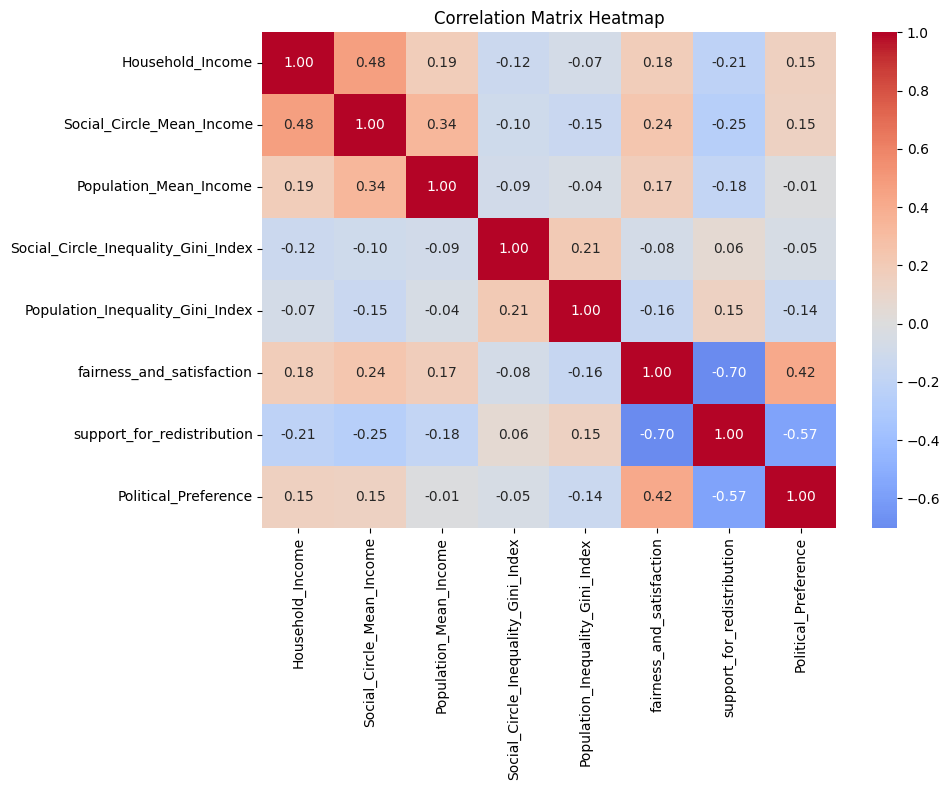

In [21]:
# Draw the heatmap here:
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()
